In [1]:
import sys
import logging
import json
import numpy as np
import pandas as pd
from datetime import datetime
import time

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS

logger = logging.getLogger(__name__)

### SETUP

In [2]:
# Load precomputed data

MODE = '6and3'
with open(f'lattice/data_{MODE}.json', 'r') as f:
    data_dict = json.load(f)
groups = data_dict['groups']
groups_direct = data_dict['groups_direct']
all_groups = {**groups, **groups_direct}
indices = data_dict['indices']
null_knobs = data_dict['null_knobs']
dfknobs = pd.read_json(f'lattice/dfknobs_{MODE}.json')

# impact of K2L difference
dfknobs.loc['SM2B',:] *= 0.25/0.2

# DO NOT CHANGE - USED TO CALCULATE ABSOLUTE K2L
initial_values_ref = {
    'SM1A': -23.68063424*0.2,
    'SM2B': 28.64315469*0.25,
    'SM1B': -25.94603546*0.2,
    'SL3': -29.46086061*0.2,
    'SL2': 35.67792145*0.2,
    'SL1': -13.27160605*0.2,
    'SH4': -15.82090071*0.2,
    'SH3': -5.85510841*0.2,
    'SH1': 19.8329121*0.2,
}

# CHANGE THIS TO VALUES FROM RING IF NEEDED
initial_values = initial_values_ref.copy()

initial_values['SM1A'] *= 1.01
initial_values['SM1B'] *= 1.008

# optimizer variables in units of K2L
variables = {'SVD0':[-0.6,0.6]} # this means SM1B will change by ~10%
# variables = {'SVD0':[-0.4,0.4]} # this means SM1B will change by ~10%

for k in ['SH1','SH3','SH4','SL1','SL2','SL3']:
    variables[k] = [-np.abs(initial_values_ref[k])*0.1,np.abs(initial_values_ref[k])*0.1]
    # variables[k] = [-np.abs(initial_values_ref[k])*0.075,np.abs(initial_values_ref[k])*0.075]

objectives_active = {'LT': 'MAXIMIZE', 'EFF':'MAXIMIZE'}

initial_variable_values = {k:0.0 for k in variables.keys()}

# Manual modifications
initial_variable_values['SH1'] -= 0.2
initial_variable_values['SH3'] -= 0.08
initial_variable_values['SL2'] -= 0.5
initial_variable_values['SL3'] -= 0.5

gvocs = GVOCS(variables=variables,
              variables_active=variables,
              objectives=objectives_active,
              objectives_active=objectives_active)

print(pd.DataFrame(initial_values_ref,index=[0]))
print(pd.DataFrame(variables))

       SM1A      SM2B      SM1B       SL3       SL2       SL1      SH4  \
0 -4.736127  7.160789 -5.189207 -5.892172  7.135584 -2.654321 -3.16418   

        SH3       SH1  
0 -1.171022  3.966582  
   SVD0       SH1       SH3       SH4       SL1       SL2       SL3
0  -0.6 -0.396658 -0.117102 -0.316418 -0.265432 -0.713558 -0.589217
1   0.6  0.396658  0.117102  0.316418  0.265432  0.713558  0.589217


In [3]:
reference_point = {'LT': 3.0, # hours
                   'EFF': 10.0 # % injected
                   }

In [4]:
import sext_tools
def compute_family_k2l_from_knob_k2l(dfknobs, knobs_dict, debug=False):
    group_relative_strengths = sext_tools.knob_strengths_to_group_strengths(dfknobs, knobs_dict)
    for k in group_relative_strengths:
        if debug:
            print(f'{k}: {initial_values[k]:.3f} + {group_relative_strengths[k]:.3f} -> {initial_values[k]+group_relative_strengths[k]:.3f}')
        group_relative_strengths[k] = group_relative_strengths[k] + initial_values[k]
    return group_relative_strengths

In [5]:
#TEST = True
TEST = False

if TEST:
    from opt_funcs_nsls import make_dummy_eval
    eval_f = make_dummy_eval(gvocs)
else:
    sys.path.insert(0, "/nsls2/users/yhidaka/git_repos/nsls2scripts3/shifts/2023-11-26_APSU_DA_MA")
    import opt_funcs

    def knobs_to_family(inputs_dict):
        d = compute_family_k2l_from_knob_k2l(dfknobs, inputs_dict, True)
        return opt_funcs.master_eval_function(d, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

    eval_f = knobs_to_family

In [6]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, True)
inputs_dict

SL1: -2.654 + -0.265 -> -2.920
SL2: 7.136 + -0.714 -> 6.422
SL3: -5.892 + -0.589 -> -6.481
SH1: 3.967 + -0.397 -> 3.570
SH3: -1.171 + -0.117 -> -1.288
SH4: -3.164 + -0.316 -> -3.481
SM1A: -4.783 + 0.398 -> -4.385
SM1B: -5.231 + -0.447 -> -5.678
SM2B: 7.161 + 0.052 -> 7.213


{'SL1': -2.9197533310000003,
 'SL2': 6.422025861000001,
 'SL3': -6.481389334200001,
 'SH1': 3.5699241780000004,
 'SH3': -1.2881238501999999,
 'SH4': -3.4805981562,
 'SM1A': -4.385288760620001,
 'SM1B': -5.6776103901960004,
 'SM2B': 7.2127339758749995}

In [7]:
if True:
    opt_funcs.master_eval_function(inputs_dict, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

Sextupole adj. took 12.6.
RMS(dx, dy) [m] = (4.703e-05, 4.763e-06)
RMS(dx, dy) [m] = (1.327e-04, 6.822e-06)
RMS(dx, dy) [m] = (3.185e-05, 4.989e-06)
RMS(dx, dy) [m] = (8.485e-05, 5.361e-06)
RMS(dx, dy) [m] = (1.365e-05, 3.257e-06)
RMS(dx, dy) [m] = (1.032e-05, 3.919e-06)
RMS(dx, dy) [m] = (2.087e-05, 8.912e-07)
RMS(dx, dy) [m] = (7.493e-06, 8.756e-07)
Orbit correction converged
** # of outliers found = 5 (out of 180)
Lifetime = 3.120 (raw tau [hr] = 3.909, epsy [pm] = 16.42) (took 5.0 [s])
Inj. Eff. = 36.57 (took 19.4 [s])
Eval. func. finished.


In [8]:
ev = FunctionEvaluator(script=eval_f)

generator_name = 'aps_mobo'
gc = get_generator_class(generator_name)

gen = gc(gvocs=gvocs)
gen.numerical_optimizer.n_raw_samples = 128 #512
gen.numerical_optimizer.n_restarts = 10
gen.gp_constructor.use_low_noise_prior = False
gen.gp_constructor.use_high_noise_prior = False
#gen.max_travel_distances = [0.1] * len(gvocs.variables_active)
gen.reference_point = reference_point

In [9]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options,
                generator=gen,
                evaluator=ev,
                gvocs=gvocs)

### Sample at initial values

In [10]:
opt.generate_at(initial_variable_values)
opt.evaluate_data()

SL1: -2.654 + 0.000 -> -2.654
SL2: 7.136 + -0.500 -> 6.636
SL3: -5.892 + -0.500 -> -6.392
SH1: 3.967 + -0.200 -> 3.767
SH3: -1.171 + -0.080 -> -1.251
SH4: -3.164 + 0.000 -> -3.164
SM1A: -4.783 + 0.000 -> -4.783
SM1B: -5.231 + 0.000 -> -5.231
SM2B: 7.161 + 0.000 -> 7.161
Sextupole adj. took 5.3.
RMS(dx, dy) [m] = (1.216e-04, 1.444e-05)
RMS(dx, dy) [m] = (2.292e-05, 5.847e-06)
RMS(dx, dy) [m] = (1.561e-04, 7.952e-06)
RMS(dx, dy) [m] = (1.351e-05, 1.003e-06)
RMS(dx, dy) [m] = (1.468e-05, 1.109e-06)
RMS(dx, dy) [m] = (3.689e-06, 1.710e-06)
Orbit correction converged
** # of outliers found = 3 (out of 180)
Lifetime = 3.846 (raw tau [hr] = 4.818, epsy [pm] = 16.38) (took 4.0 [s])
Inj. Eff. = 4.19 (took 16.0 [s])
Eval. func. finished.


In [11]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,0.0,-0.2,-0.08,0.0,0.0,-0.5,-0.5,"{'_nux': 0.20570257065981729, '_nuy': 0.268003...",None,,...,True,0.205703,0.268004,2.185568e-09,1.653258e-11,2.209514e-09,1.637865e-11,3.845968,4.818205,4.187326


### Sample close to initial point

In [12]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=1, point=initial_variable_values, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

SL1: -2.654 + -0.006 -> -2.660
SL2: 7.136 + -0.482 -> 6.654
SL3: -5.892 + -0.508 -> -6.400
SH1: 3.967 + -0.187 -> 3.780
SH3: -1.171 + -0.080 -> -1.251
SH4: -3.164 + 0.005 -> -3.159
SM1A: -4.783 + -0.007 -> -4.790
SM1B: -5.231 + 0.008 -> -5.223
SM2B: 7.161 + -0.001 -> 7.160
Sextupole adj. took 0.1.
RMS(dx, dy) [m] = (3.790e-05, 1.901e-05)
RMS(dx, dy) [m] = (1.460e-05, 9.785e-06)
RMS(dx, dy) [m] = (1.030e-05, 3.007e-06)
RMS(dx, dy) [m] = (1.773e-05, 9.752e-06)
RMS(dx, dy) [m] = (6.255e-06, 2.894e-06)
Orbit correction converged
** # of outliers found = 2 (out of 180)
Lifetime = 3.895 (raw tau [hr] = 4.871, epsy [pm] = 16.34) (took 4.0 [s])
Inj. Eff. = 2.99 (took 17.0 [s])
Eval. func. finished.


In [13]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,0.000000,-0.200000,-0.080000,0.00000,0.000000,-0.500000,-0.500000,"{'_nux': 0.20570257065981729, '_nuy': 0.268003...",None,,...,True,0.205703,0.268004,2.185568e-09,1.653258e-11,2.209514e-09,1.637865e-11,3.845968,4.818205,4.187326
2,0.010133,-0.186588,-0.080199,0.00518,-0.005754,-0.482048,-0.508045,"{'_nux': 0.2062773166563648, '_nuy': 0.2672714...",None,,...,True,0.206277,0.267271,2.219417e-09,1.645138e-11,2.206530e-09,1.634399e-11,3.894681,4.871128,2.985835


### Run optimizer

In [14]:
opt.step()

/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/botorch/optim/initializers.py:404: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


SL1: -2.654 + -0.258 -> -2.912
SL2: 7.136 + 0.586 -> 7.722
SL3: -5.892 + 0.366 -> -5.526
SH1: 3.967 + -0.026 -> 3.940
SH3: -1.171 + 0.101 -> -1.070
SH4: -3.164 + 0.237 -> -2.927
SM1A: -4.783 + 0.320 -> -4.464
SM1B: -5.231 + -0.359 -> -5.590
SM2B: 7.161 + 0.042 -> 7.203
Sextupole adj. took 12.6.
RMS(dx, dy) [m] = (9.110e-05, 6.466e-06)
RMS(dx, dy) [m] = (2.457e-05, 4.984e-06)
RMS(dx, dy) [m] = (5.602e-05, 3.379e-06)
RMS(dx, dy) [m] = (2.454e-04, 5.854e-06)
RMS(dx, dy) [m] = (3.498e-05, 4.736e-06)
RMS(dx, dy) [m] = (2.046e-05, 2.755e-06)
RMS(dx, dy) [m] = (1.140e-05, 3.127e-06)
RMS(dx, dy) [m] = (2.454e-05, 6.339e-06)
RMS(dx, dy) [m] = (4.290e-06, 3.431e-06)
Orbit correction converged
** # of outliers found = 3 (out of 180)
Lifetime = 11.203 (raw tau [hr] = 14.035, epsy [pm] = 16.44) (took 8.0 [s])
Inj. Eff. = 7.98 (took 20.1 [s])
Eval. func. finished.


In [15]:
for i in range(20):
    print(f'\n** Step #{i+1} at {datetime.now():%Y-%m-%d %H:%M:%S}**\n')
    opt.step()


** Step #1 at 2023-11-26 22:03:09**

SL1: -2.654 + -0.265 -> -2.919
SL2: 7.136 + 0.627 -> 7.762
SL3: -5.892 + 0.384 -> -5.508
SH1: 3.967 + 0.266 -> 4.233
SH3: -1.171 + 0.104 -> -1.067
SH4: -3.164 + 0.242 -> -2.922
SM1A: -4.783 + 0.328 -> -4.456
SM1B: -5.231 + -0.368 -> -5.599
SM2B: 7.161 + 0.043 -> 7.204
Sextupole adj. took 3.2.
RMS(dx, dy) [m] = (4.261e-05, 1.853e-06)
RMS(dx, dy) [m] = (4.139e-05, 3.838e-06)
RMS(dx, dy) [m] = (1.081e-05, 2.774e-06)
RMS(dx, dy) [m] = (7.479e-06, 1.065e-06)
Orbit correction converged
** # of outliers found = 3 (out of 180)
* eps_y too large! Lifetime value set to NaN.
Lifetime = nan (raw tau [hr] = 20.148, epsy [pm] = 32.58) (took 10.6 [s])
Inj. Eff. = 2.32 (took 16.0 [s])
Eval. func. finished.

** Step #2 at 2023-11-26 22:03:55**

SL1: -2.654 + -0.256 -> -2.911
SL2: 7.136 + 0.576 -> 7.712
SL3: -5.892 + 0.363 -> -5.529
SH1: 3.967 + -0.214 -> 3.752
SH3: -1.171 + 0.101 -> -1.070
SH4: -3.164 + 0.236 -> -2.928
SM1A: -4.783 + 0.319 -> -4.465
SM1B: -5.231 + 

In [16]:
opt.data.tail()

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
19,-0.600000,-0.396658,0.098329,0.195902,-0.229587,-0.001383,0.268022,"{'_nux': 0.2180773739976842, '_nuy': 0.2502427...",None,,...,True,0.218077,0.250243,2.154246e-09,2.186441e-11,2.148658e-09,2.163378e-11,6.185407,8.982627,73.992345
20,-0.600000,-0.396658,0.043288,0.132499,-0.226838,-0.043730,0.027900,"{'_nux': 0.21433391170065594, '_nuy': 0.254332...",None,,...,True,0.214334,0.254332,2.168691e-09,1.962091e-11,2.151992e-09,2.121955e-11,5.571952,8.018319,79.605385
21,-0.600000,-0.358636,0.056398,0.143851,-0.244280,-0.313159,0.215822,"{'_nux': 0.21429322671260673, '_nuy': 0.249408...",None,,...,True,0.214293,0.249409,2.181822e-09,1.944598e-11,2.152788e-09,2.088089e-11,5.526967,7.893065,79.032110
22,-0.600000,-0.364217,0.071591,0.148611,-0.260660,-0.572413,0.213397,"{'_nux': 0.21295046087189154, '_nuy': 0.254240...",None,,...,True,0.212950,0.254241,2.159715e-09,1.917068e-11,2.153457e-09,2.078809e-11,5.308303,7.566539,32.514590
23,-0.563915,-0.298333,0.068341,0.145066,-0.182403,-0.137754,0.189494,"{'_nux': 0.2169787583940371, '_nuy': 0.2526841...",None,,...,True,0.216979,0.252684,2.151863e-09,2.030655e-11,2.154666e-09,2.065316e-11,6.107185,8.681939,81.482580


Text(0, 0.5, 'Hypervolume')

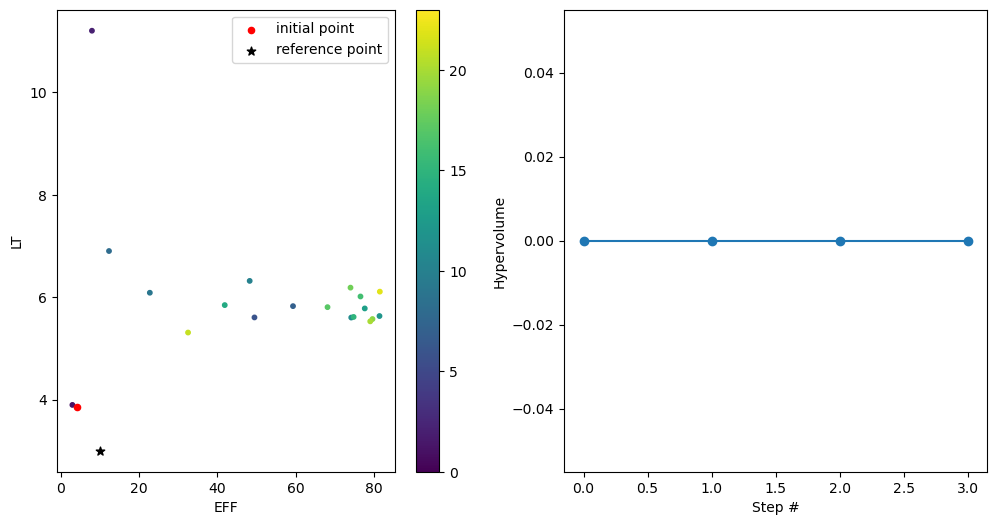

In [20]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(i)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

In [22]:
hvs

[0.0,
 0.0,
 0.0,
 0.0,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]

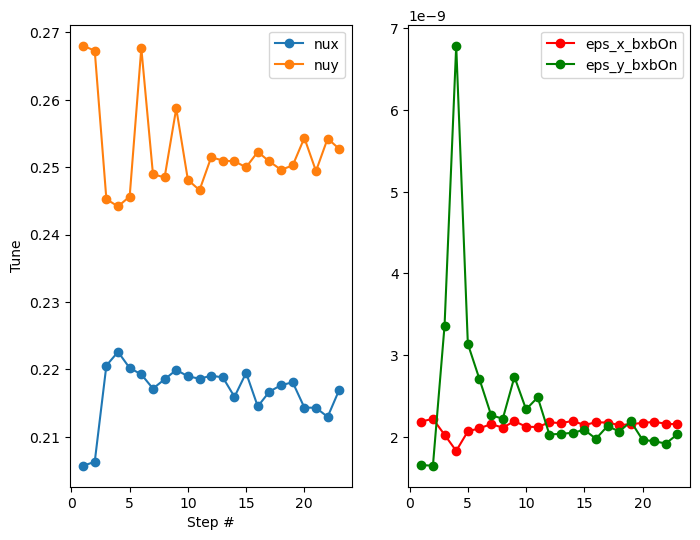

In [18]:
fig,ax = plt.subplots(1,2,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,'_nux'], marker='o', label='nux')
ax[0,0].plot(df.loc[:,'_nuy'], marker='o', label='nuy')
ax[0,1].plot(df.loc[:,'_eps_x_bxbOn'], marker='o', label='eps_x_bxbOn', color='red')
ax[0,1].plot(df.loc[:,'_eps_y_bxbOn']*1e2, marker='o', label='eps_y_bxbOn', color='green')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Tune')
ax[0,0].legend()
ax[0,1].legend()

In [19]:
# This will save optimizer state
from datetime import datetime
opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_exp_mobo_{MODE}_v1_dump.json')

'{\n  "optimizer": {\n    "tag": "df860ddc2a",\n    "store_history": true,\n    "dump_every_step": true,\n    "history_directory": null,\n    "execution_mode": "sync"\n  },\n  "generator": {\n    "name": "aps_mobo",\n    "n_monte_carlo_samples": 128,\n    "turbo_controller": null,\n    "use_cuda": false,\n    "gp_constructor": {\n      "name": "mobo_model",\n      "use_low_noise_prior": false,\n      "covar_modules": {},\n      "mean_modules": {},\n      "trainable_mean_keys": [],\n      "use_high_noise_prior": false\n    },\n    "numerical_optimizer": {\n      "name": "APSLBFGS",\n      "n_raw_samples": 128,\n      "n_restarts": 10,\n      "max_iter": 2000,\n      "sequential": true\n    },\n    "max_travel_distances": null,\n    "fixed_features": null,\n    "computation_time": null,\n    "n_candidates": 1,\n    "reference_point": {\n      "LT": 3.0,\n      "EFF": 10.0\n    },\n    "prune_inferior_points_kwargs": null\n  },\n  "evaluator": {\n    "name": "func",\n    "on_error": "igno